# Download

The PBMC datasets were obtained from https://github.com/satijalab/seurat-data and saved as csv files.
The original datasets are in https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE132044

# Sensitivity analysis
Here we provide code for sensitivity analysis. This is an example of running Portal with parameters lcos = 20, lae = 10, lea = 10, m = 500, t = 5. Performance metrics are evaluated in this example. Change parameters in the third "cell" to perform the sensitivity analysis. 

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import portal
import anndata

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
data_path = "data_sensitivity/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

result_path = "results_sensitivity/"
if not os.path.exists(result_path):
    os.makedirs(result_path)

mtx_A = pd.read_csv("cnt_10x.csv", index_col = 0).T
adata_A = anndata.AnnData(X = mtx_A.values)
adata_A.obs.index = mtx_A.index
adata_A.obs["method"] = "10X"
adata_A.var.index = mtx_A.columns

celltype_A = pd.read_csv("celltype_10x.csv", index_col = 0)
adata_A.obs["celltype"] = celltype_A.values

mtx_B = pd.read_csv("cnt_indrops.csv", index_col = 0).T
adata_B = anndata.AnnData(X = mtx_B.values)
adata_B.obs.index = mtx_B.index
adata_B.obs["method"] = "inDrops"
adata_B.var.index = mtx_B.columns

celltype_B = pd.read_csv("celltype_indrops.csv", index_col = 0)
adata_B.obs["celltype"] = celltype_B.values

meta = pd.concat([adata_A.obs, adata_B.obs])

meta = pd.concat([adata_A.obs, adata_B.obs])
meta = meta.replace("CD4+ T cell", "T cell")
meta = meta.replace("Cytotoxic T cell", "T cell")
meta = meta.replace("CD14+ monocyte", "Mono")
meta = meta.replace("CD16+ monocyte", "Mono")

In [3]:
# Parameters can be set here

lcos = 20.0
lae = 10.0
lea = 10.0
m = 500
t = 5.0

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


Normalizing and scaling...


/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


Dimensionality reduction via PCA...
Begining time:  Thu Mar 17 20:02:20 2022
step 0, loss_D=9.499032, loss_GAN=2.844378, loss_AE=174.033066, loss_cos=38.253616, loss_LA=129.384018
step 200, loss_D=2.912441, loss_GAN=2.627915, loss_AE=10.730621, loss_cos=4.742882, loss_LA=2.224687
step 400, loss_D=2.361604, loss_GAN=2.291337, loss_AE=7.112873, loss_cos=3.134823, loss_LA=1.170576
step 600, loss_D=2.399822, loss_GAN=2.301024, loss_AE=5.429869, loss_cos=2.986072, loss_LA=0.838134
step 800, loss_D=2.071423, loss_GAN=2.463070, loss_AE=4.666562, loss_cos=2.731022, loss_LA=0.652943
Ending time:  Thu Mar 17 20:02:45 2022
Training takes 25.29 seconds
Begining time:  Thu Mar 17 20:02:45 2022
Ending time:  Thu Mar 17 20:02:45 2022
Evaluating takes 0.05 seconds
UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Thu Mar 17 20:02:45 2022 Finding Nearest N

/home/jzhaoaz/.conda/envs/scUNIT/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Thu Mar 17 20:02:57 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


... storing 'method' as categorical
... storing 'celltype' as categorical


Thu Mar 17 20:03:21 2022 Finished embedding


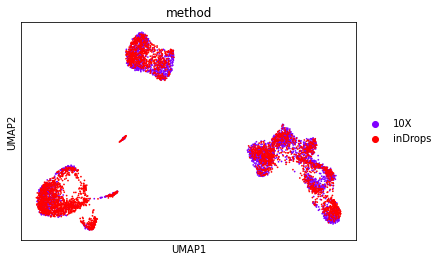

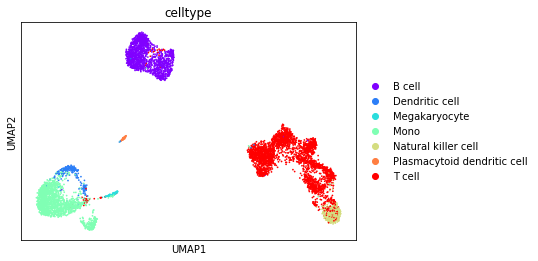

In [4]:
model = portal.model.Model(training_steps=1000, data_path=os.path.join(data_path, "preprocess"), 
                           model_path="./models_sensitivity", 
                           result_path=result_path)
model.preprocess(adata_A, adata_B, save_embedding=True)

model.lambdacos = lcos
model.lambdaAE = lae
model.lambdaEA = lea
model.batch_size = m
model.margin = t

model.train()
model.eval(save_results=True)

np.save(os.path.join(model.result_path, "latent.npy"), np.array(model.latent))

portal.utils.plot_UMAP(model.latent, meta, space="latent", colors=["method", "celltype"], save=True, result_path=model.result_path)

Prediction accuracy

In [5]:
lowdim_10X = model.latent[:adata_A.shape[0]]
lowdim_indrops = model.latent[adata_A.shape[0]:]
celltype_10X = meta["celltype"].values[:adata_A.shape[0]]
celltype_indrops = meta["celltype"].values[adata_A.shape[0]:]

celltype_10X_pred = portal.utils.annotate_by_nn(lowdim_10X, lowdim_indrops, celltype_indrops, k=20, metric='euclidean')
celltype_10X_pred_acc = np.sum(celltype_10X == celltype_10X_pred) / lowdim_10X.shape[0]

print("Prediction accuracy: ", celltype_10X_pred_acc)

Prediction accuracy:  0.9824509220701964


LISI scores

In [6]:
# Graph iLISI and Graph cLISI
# We compute the lisi scores following https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html
# lisi.py is from https://github.com/theislab/scib/tree/main/scib/metrics
# knn_graph is from https://github.com/theislab/scib/tree/main/scib

def compute_scib_metrics(adata, emb_key, label_key, batch_key, model_name):
    from lisi import lisi_graph

    emb_key_ = "X_emb"
    adata.obsm[emb_key_] = adata.obsm[emb_key]
    sc.pp.neighbors(adata, use_rep=emb_key_)
    df = pd.DataFrame(index=[model_name])
    df["ilisi"], df["clisi"] = lisi_graph(adata, batch_key, label_key, type_="embed")

    return df

In [7]:
adata = anndata.AnnData(X=model.latent)
adata.obsm["emb"] = model.latent
adata.obs["batch"] = list(meta["method"].values)
adata.obs["batch"] = adata.obs["batch"].astype('category')
adata.obs["celltype"] = list(meta["celltype"].values)
adata.obs["celltype"] = adata.obs["celltype"].astype('category')

metrics = compute_scib_metrics(adata, emb_key="emb", label_key="celltype", batch_key="batch", model_name="Portal")

print("Graph iLISI: ", metrics["ilisi"].values)
print("Graph cLISI: ", metrics["clisi"].values)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


/tmp/lisi_9cg8wd8c/input.mtx /tmp/lisi_9cg8wd8c/


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


/tmp/lisi_8nazj1tz/input.mtx /tmp/lisi_8nazj1tz/
Graph iLISI:  [0.74538276]
Graph cLISI:  [1.]
